# Applying flat-field corrections

`opticam` provides a simple interface for creating and applying image corrections (currently limited to flat-field corrections).

In this notebook, I will demonstrate how to create a master flat, and how this master flat can be incorporated into the reduction process.

## Generating Synthetic Data and Flats

Before applying flat-field corrections, we need some flat-field images. For this tutorial, I will use the `generate_flats()` routine to generate some synethetic flats. I will also generate some synthetic observations using `generate_observations()` with `circular_aperture=True` to impose a circular aperture shadow onto the images:

In [1]:
import opticam

opticam.generate_observations(
    out_dir='corrections_tutorial/data',
    n_images=10,  # number of images per camera
    circular_aperture=True,  # impose circular aperture shadow on images
    )

opticam.generate_flats(
    out_dir='corrections_tutorial/flats',
    n_flats=5,  # number of flats per camera
)

[OPTICAM] variable source is at (131, 115)
[OPTICAM] variability RMS: 0.02 %
[OPTICAM] variability frequency: 0.135 Hz
[OPTICAM] variability phase lags:
    [OPTICAM] g-band: 0.000 radians
    [OPTICAM] r-band: 1.571 radians
    [OPTICAM] i-band: 3.142 radians


Generating observations: 100%|██████████|[00:05<00:00]
Generating flats: 100%|██████████|[00:03<00:00]


Let's check if our newly created flats are where they should be:

In [2]:
import os

flats = os.listdir('corrections_tutorial/flats')
for file in flats[:3]:
    print(file)

i-band_flat_4.fits.gz
r-band_flat_4.fits.gz
i-band_flat_0.fits.gz


We have flats! Note that these files are compressed using `gzip` to reduce disk space. FITS files do not need to be unzipped to be compatible with `opticam` since `astropy.io.fits`, which is used by `opticam` to handle FITS files, can seamlessly open `fits.gz` files.

Let's take a look at one of our newly-generated flats:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
FILTER  = 'i       '                                                            
BINNING = '4x4     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:04'                                                 


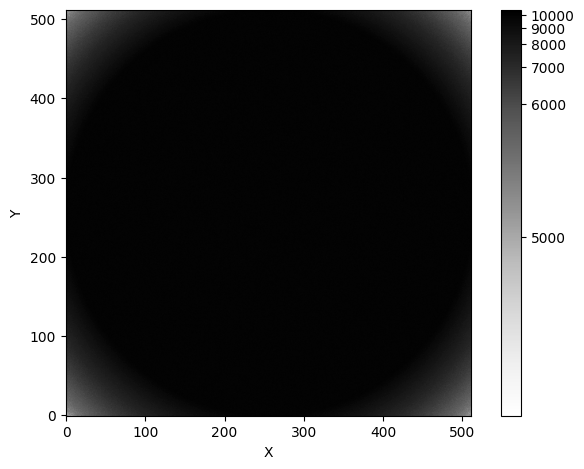

In [3]:
from astropy.io import fits
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt
import numpy as np

# open the first flat field image
file = flats[0]
with fits.open(f'corrections_tutorial/flats/{file}') as hdul:
    print(repr(hdul[0].header))
    flat = np.array(hdul[0].data)

# plot the flat field image
fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(
    flat,
    norm=simple_norm(
        flat,
        stretch="log",
        ),
    origin="lower",
    cmap="Greys",
    )

fig.colorbar(im)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

These synthetic flats show a circular shadow that you might imagine was caused by the telescope's circular aperture. We also see this shadow in the synthetic observations created by `opticam.generate_observations()`:

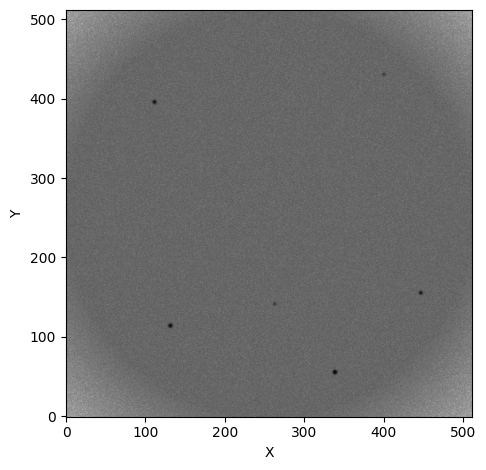

In [4]:
# get the first image
files = sorted(os.listdir('corrections_tutorial/data'))
file = files[0]

# open the image
with fits.open(f"corrections_tutorial/data/{file}") as hdul:
    image = np.array(hdul[0].data)

# plot the image
fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(
    image,
    norm=simple_norm(
        image,
        stretch="log",
        ),
    origin="lower",
    cmap="Greys",
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

Just like in the flats, we see a circular shadow at the corners of the image.

Let's see what happens if we neglect flat-field corrections:

[OPTICAM] corrections_tutorial/reduced_no_corrections not found, attempting to create ...
[OPTICAM] corrections_tutorial/reduced_no_corrections created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 10 g-band images.
[OPTICAM] 10 r-band images.
[OPTICAM] 10 i-band images.


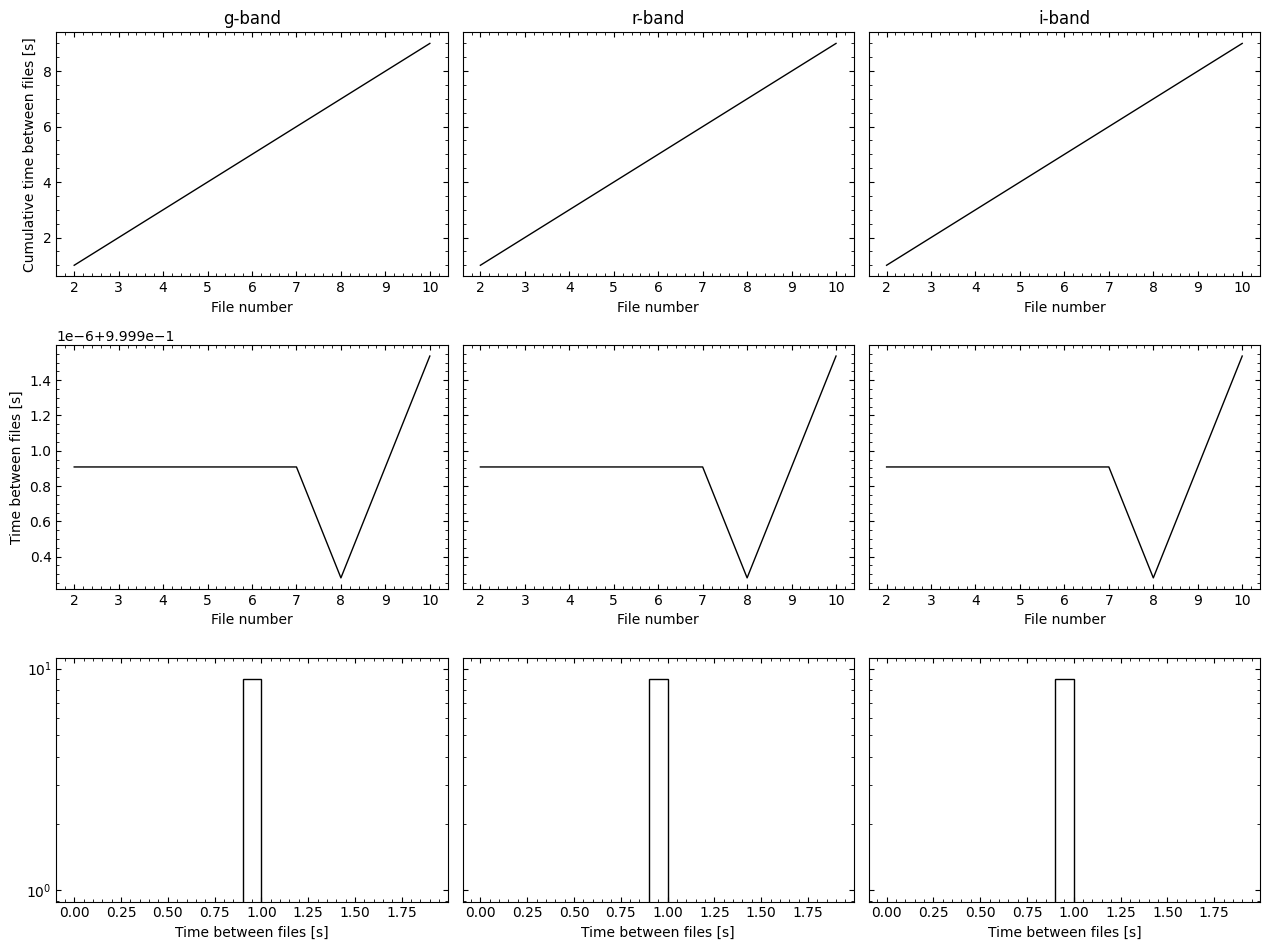

[OPTICAM] Creating source catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


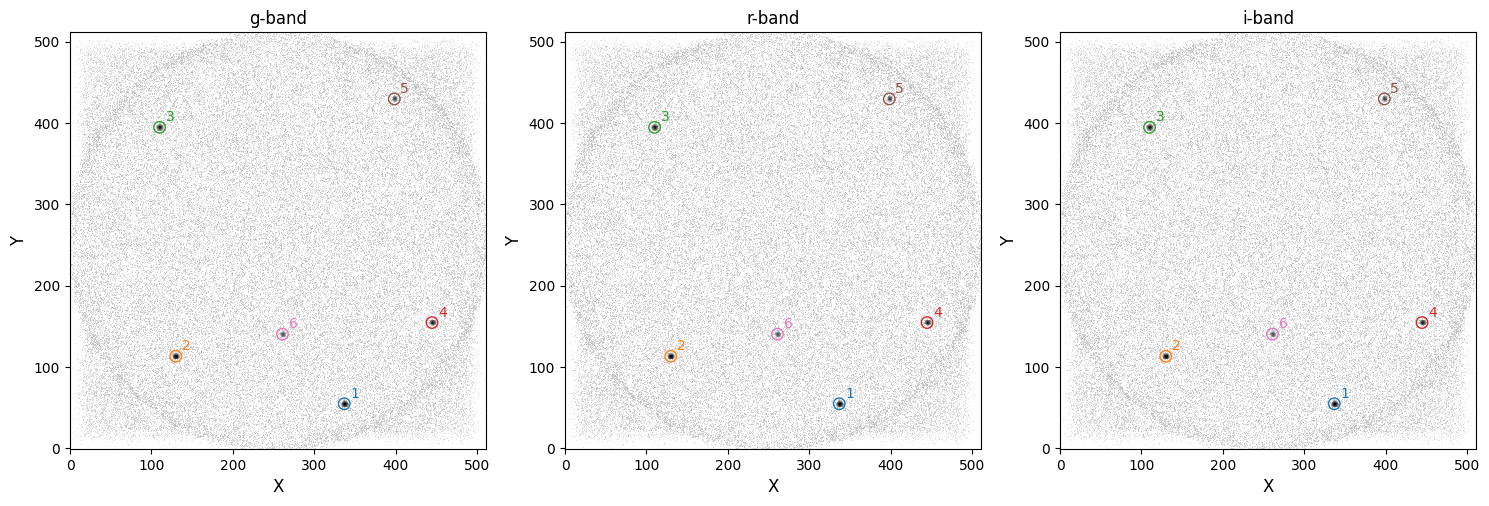

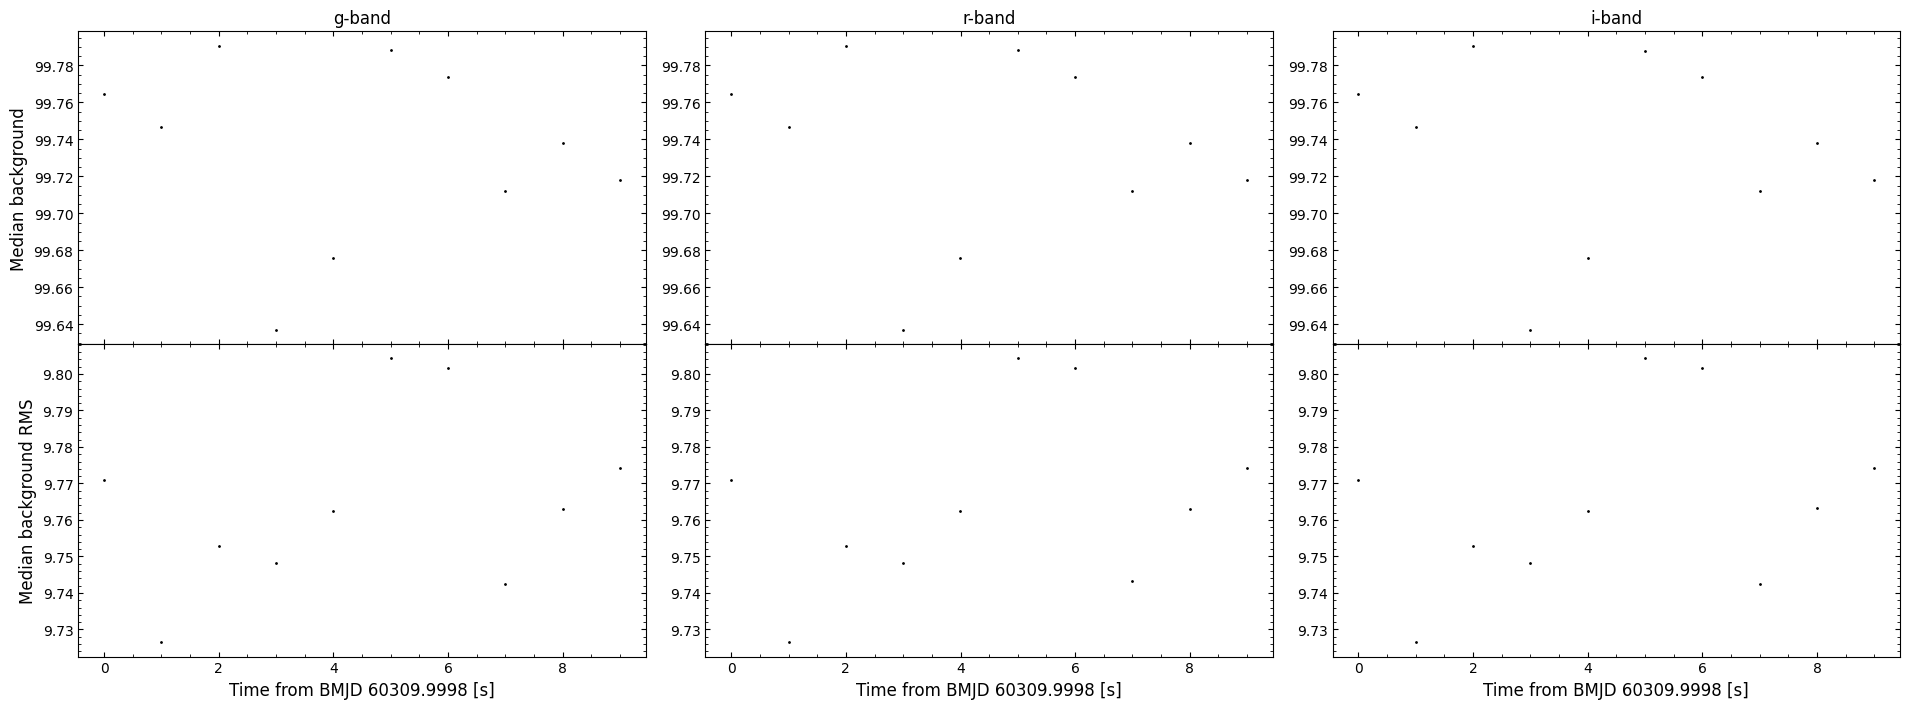

In [5]:
reducer = opticam.Reducer(
    data_directory='corrections_tutorial/data',  # path to the simulated data
    out_directory='corrections_tutorial/reduced_no_corrections',  # path to where output will be saved
    show_plots=True,
    remove_cosmic_rays=False,
    )

reducer.create_catalogs()

As we can see, systematic artefacts get worse in the stacked image. Not only can systematic artefacts therefore skew flux measurements, but they may also lead to spurious source detections. It's therefore important to correct for these effects.

## Applying Flat-field Corrections

In `opticam`, flat-field corrections are handled by an `opticam.FlatFieldCorrector` object. Like `opticam.Catalog`, `opticam.FlatFieldCorrector` will split flats by filter if they are all stored in a single directory, or separate directories can be specified for each filter's flats. In this example, all flats are stored in a single directory:

In [6]:
flat_corrector = opticam.FlatFieldCorrector(
    out_directory='corrections_tutorial/correctors',  # where the master flat field images will be stored
    flats_directory='corrections_tutorial/flats',  # where the flat field images are stored
    )

[OPTICAM] 5 i-band flat-field images.
[OPTICAM] 5 r-band flat-field images.
[OPTICAM] 5 g-band flat-field images.


When defining a `FlatFieldCorrector` object, an `out_dir` must be specified. This is the directory to which any output files (e.g., the master flats) will be written. 

After creating a `FlatFieldCorrector` instance, you will be able to see how many flats have been detected for each camera. In this case, we can see that each filter has five flat-field images.

### Creating Master Flats (Long Way)

Now that we have a `FlatFieldCorrector` instance, we can either create master flats manually, or pass the `FlatFieldCorrector` object to a `Catalog` instance, which will automatically create the master flats for us if they do not already exist. In this example, let's create the master flats manually:

In [7]:
flat_corrector.create_master_flats()

Let's take a look at these master flats. We can either read the master flats from their new directory:

In [8]:
os.listdir('corrections_tutorial/correctors')

['master_flats.fits.gz']

where we can see that the master flats are stored in a compressed FITS file, or we can access the master flats directly from `flat_corrector` using the `master_flats` attribute:

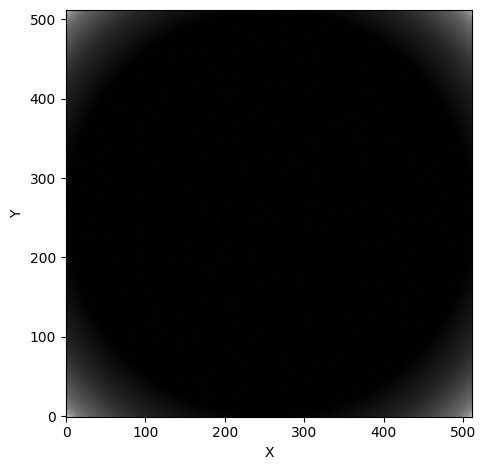

In [9]:
master_flat = flat_corrector.master_flats['g-band']

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(
    master_flat,
    norm=simple_norm(
        master_flat,
        stretch="log",
        ),
    origin="lower",
    cmap="Greys",
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

Let's take a quick look at the master flats file:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT This FITS file contains master flat-field images for each filter.       

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
FILTER  = 'i-band  '       

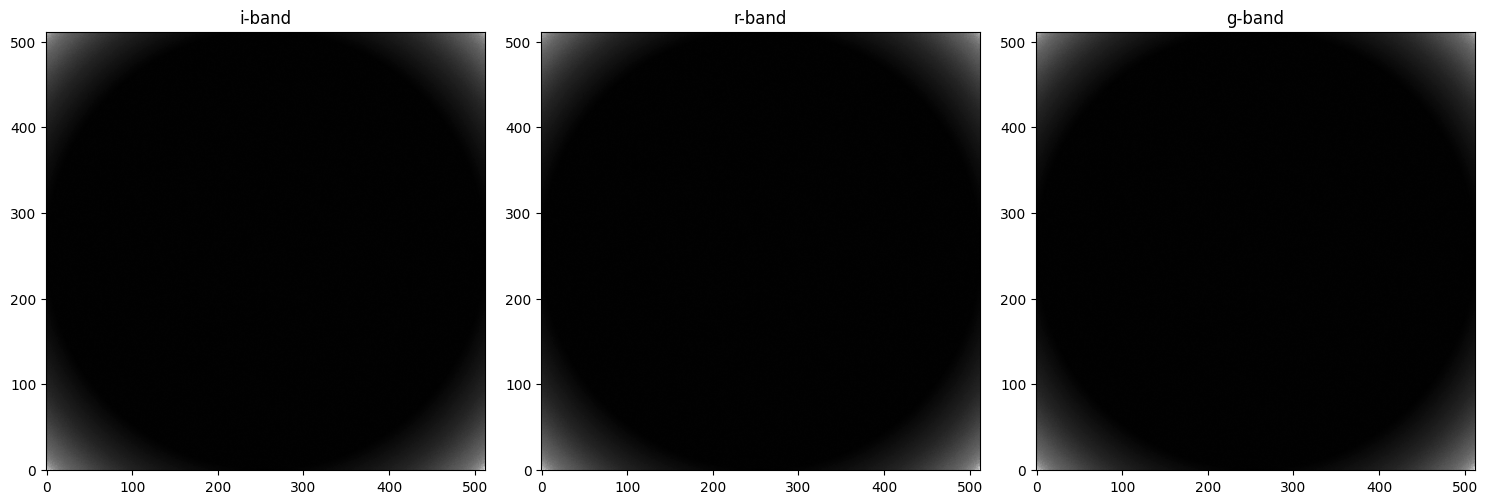

In [10]:
fig, axes = plt.subplots(
    ncols=3,
    tight_layout=True,
    figsize=(15, 5),
    )

with fits.open('corrections_tutorial/correctors/master_flats.fits.gz') as hdul:
    for i, hdu in enumerate(hdul):
        print(repr(hdu.header))
        print()
        
        # skip primary HDU
        if i > 0:
            fltr = hdu.header['FILTER']  # get master flat filter
            master_flat = hdu.data  # get master flat
            axes[i - 1].imshow(
                master_flat,
                norm=simple_norm(
                    master_flat,
                    stretch="log",
                    ),
                origin="lower",
                cmap="Greys",
                )
            axes[i - 1].set_title(fltr)

plt.show()

As we can see, the master flats file is a compressed FITS cube storing the master flat for each filter. The primary HDU is empty, and only needed for compatibility. The remaining HDUs contain the master flat field images, and the headers contain information about the image (notably, the image's filter).

### Performing Flat-field Corrections

Let's now use `flat_corrector` to correct an image:

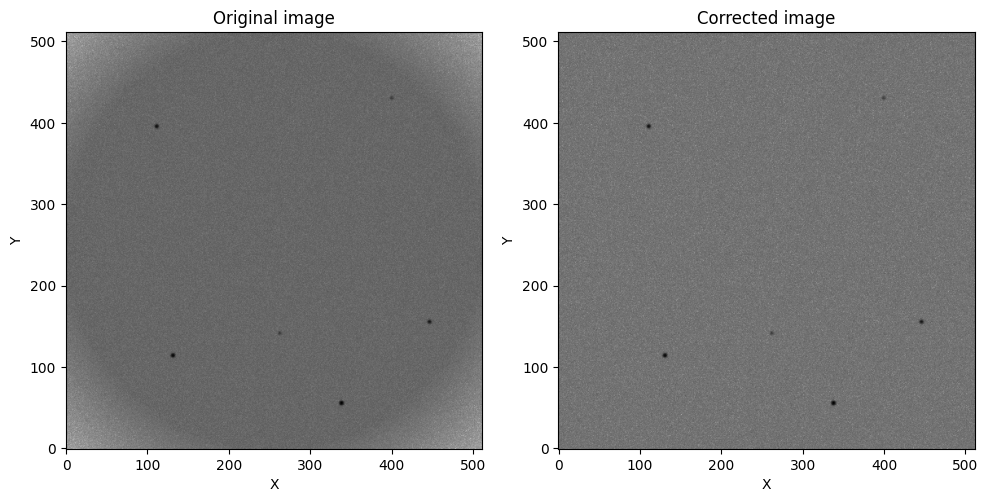

In [11]:
with fits.open(f'corrections_tutorial/data/{files[0]}') as hdul:
    fltr = hdul[0].header['FILTER'] + '-band'
    image = np.array(hdul[0].data)

fig, axes = plt.subplots(
    ncols=2,
    tight_layout=True,
    figsize=(10, 5),
    )

axes[0].imshow(
    image,
    norm=simple_norm(
        image,
        stretch="log",
        ),
    origin="lower",
    cmap="Greys",
    )
axes[0].set_title('Original image')

corrected_image = flat_corrector.correct(image, fltr)

axes[1].imshow(
    corrected_image,
    norm=simple_norm(
        corrected_image,
        stretch="log",
        ),
    origin="lower",
    cmap="Greys",
    )
axes[1].set_title('Corrected image')

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.show()

As we can see, the aperture shadow has been removed!

We can automate the process of applying master flats by passing an `opticam.FlatFieldCorrector` instance to `opticam.Catalog`:

[OPTICAM] corrections_tutorial/reduced not found, attempting to create ...
[OPTICAM] corrections_tutorial/reduced created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 10 g-band images.
[OPTICAM] 10 r-band images.
[OPTICAM] 10 i-band images.


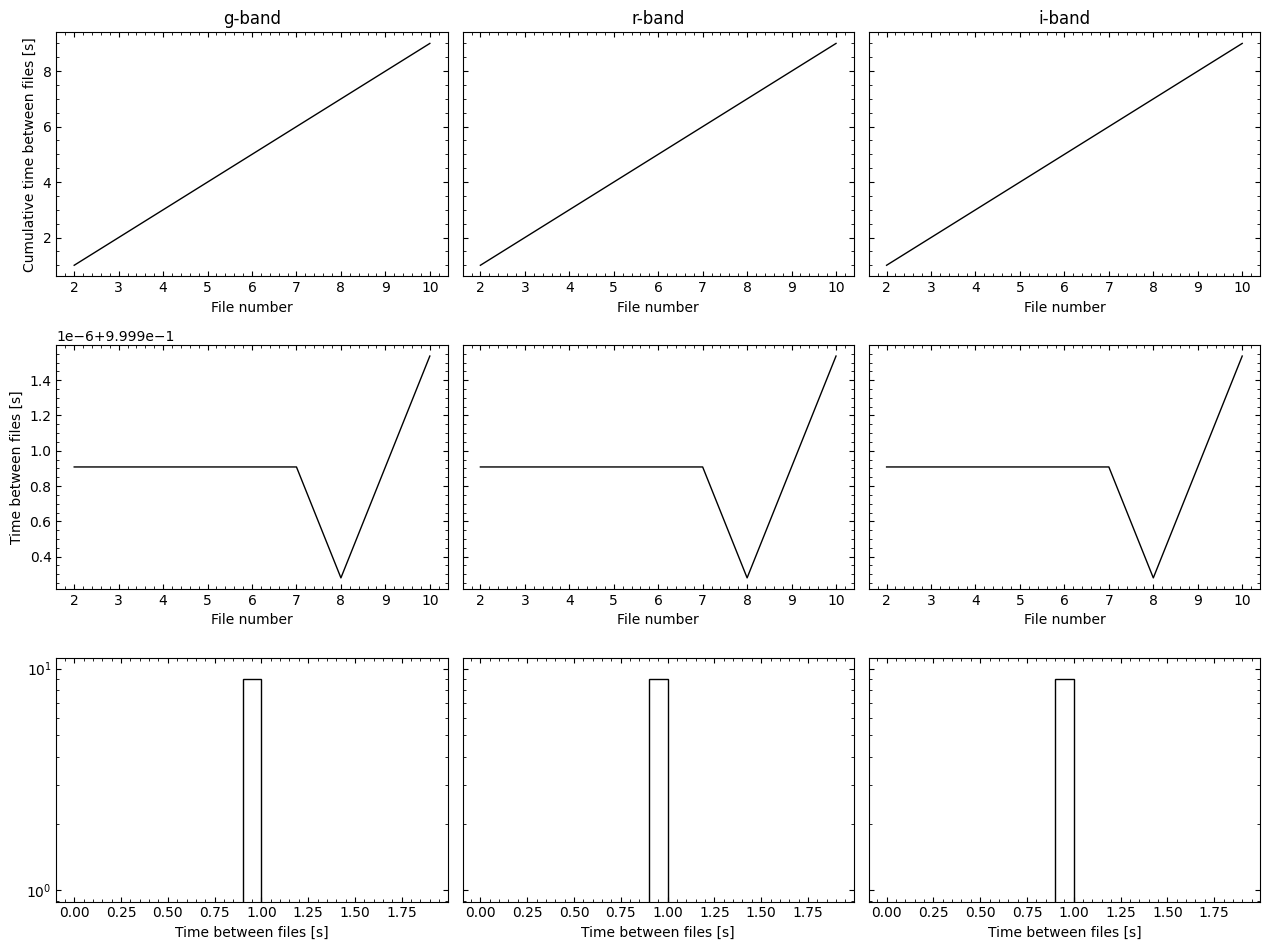

In [12]:
reducer = opticam.Reducer(
    data_directory='corrections_tutorial/data',  # path to the simulated data
    out_directory='corrections_tutorial/reduced',  # path to where output will be saved
    show_plots=True,
    flat_corrector=flat_corrector,  # pass the flat field corrector
    remove_cosmic_rays=False,
    )

[OPTICAM] Creating source catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


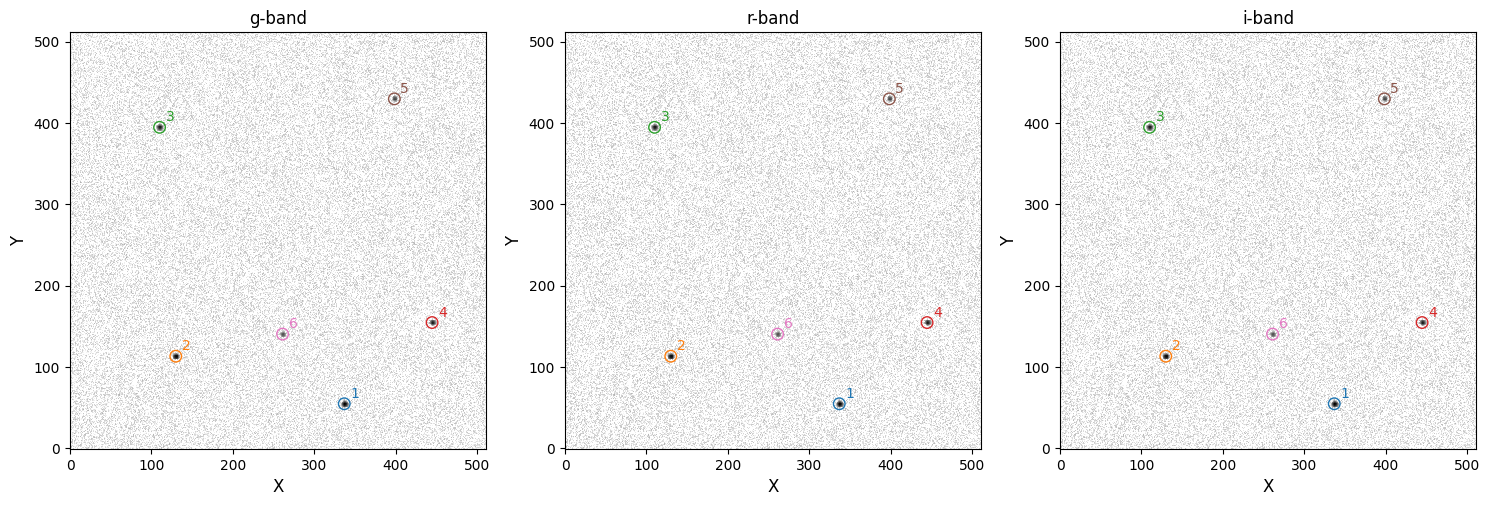

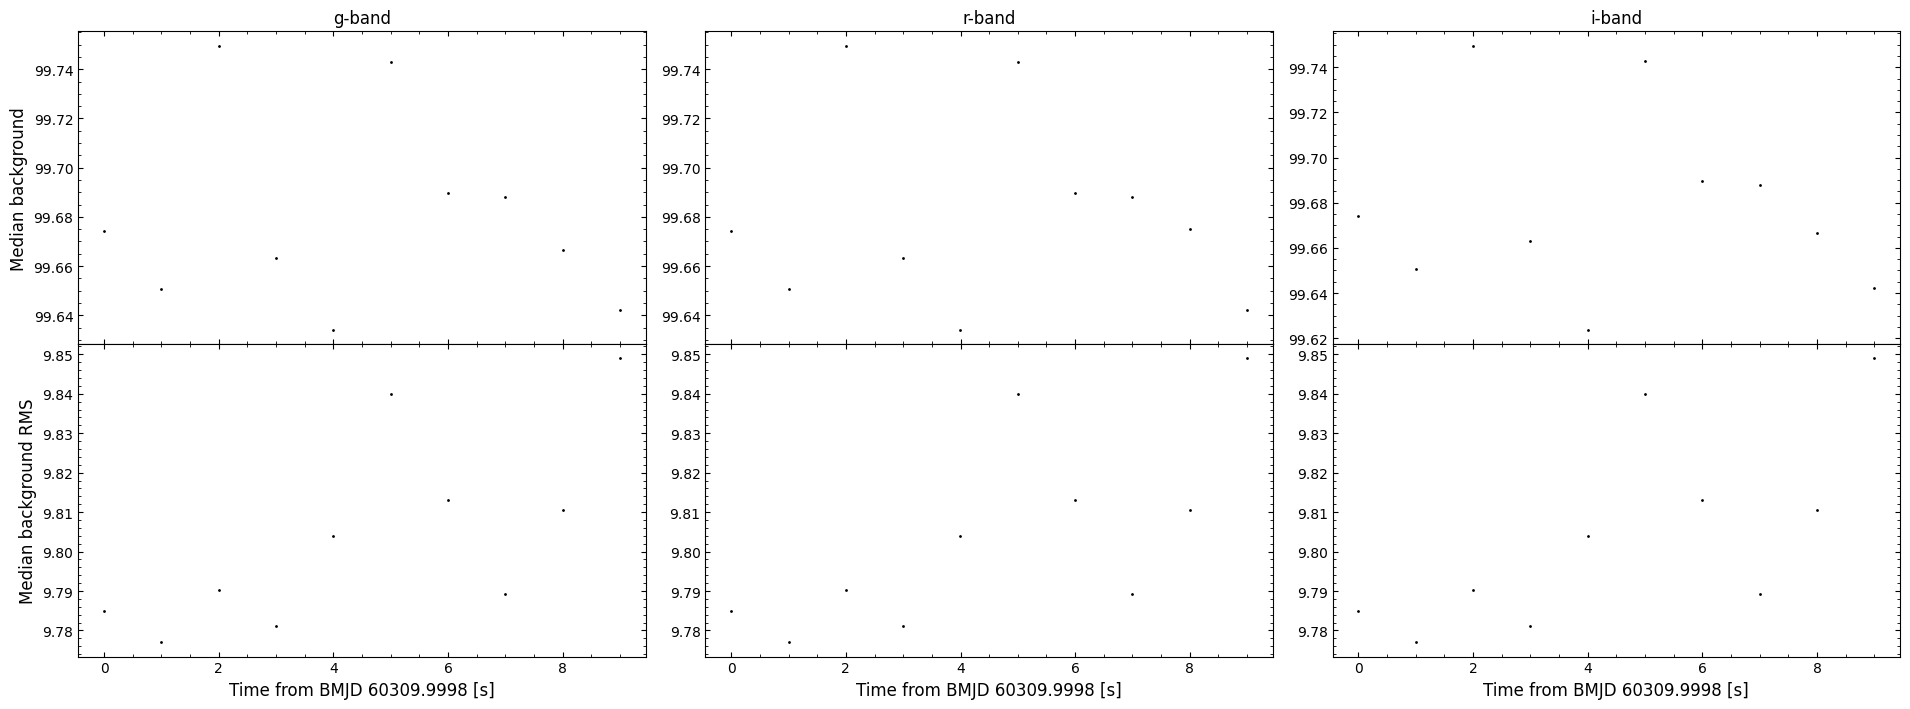

In [13]:
reducer.create_catalogs()

As we can see, the catalog images also do not show an aperture shadow. 

### Creating Master Flats (Short Way)

We can create master flat-field images with fewer lines of code by letting `opticam` handle the master flat creation automatically:

[OPTICAM] 5 i-band flat-field images.
[OPTICAM] 5 r-band flat-field images.
[OPTICAM] 5 g-band flat-field images.
[OPTICAM] corrections_tutorial/reduced_auto not found, attempting to create ...
[OPTICAM] corrections_tutorial/reduced_auto created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 10 g-band images.
[OPTICAM] 10 r-band images.
[OPTICAM] 10 i-band images.


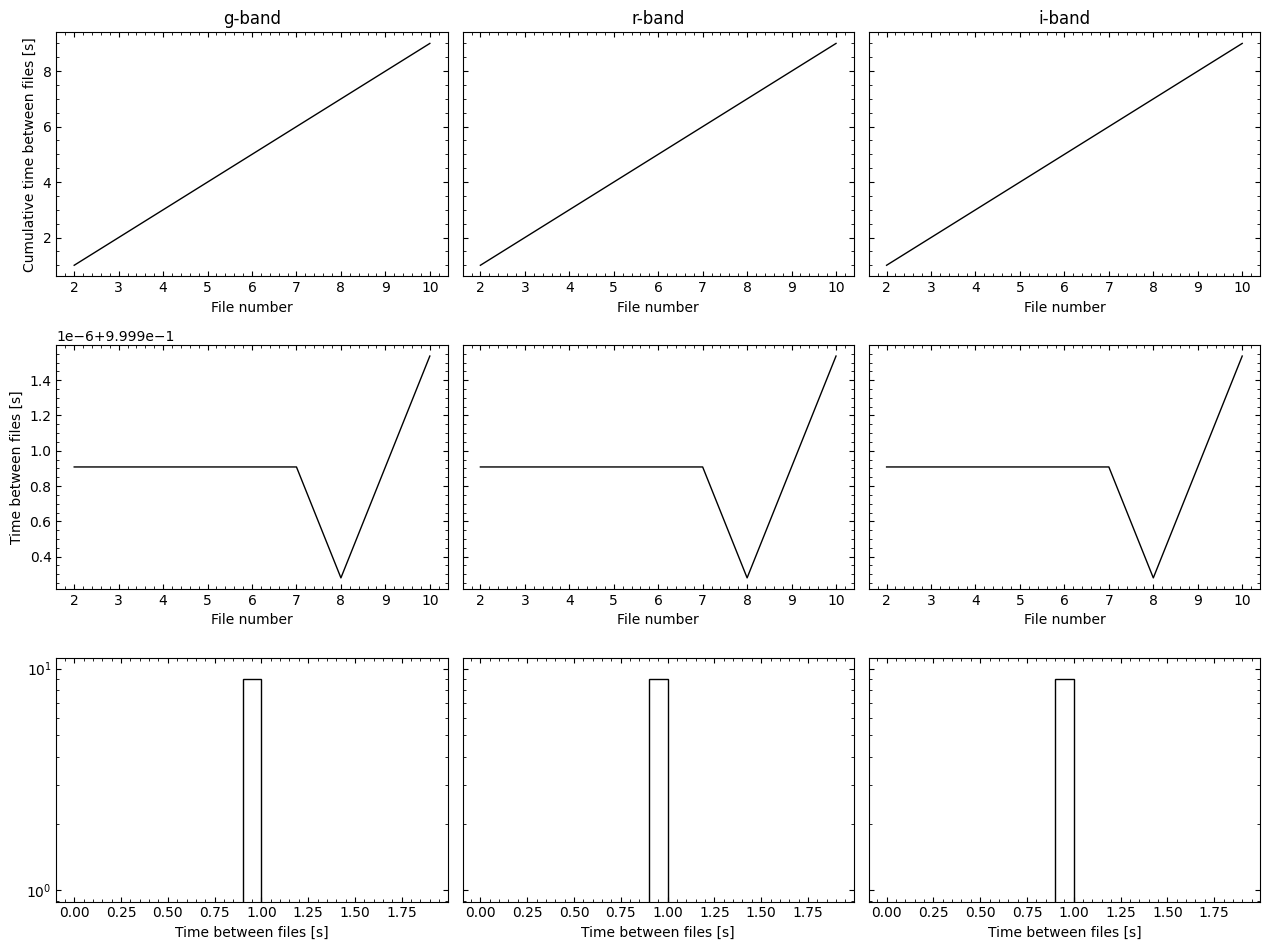

In [14]:
auto_flat_corrector = opticam.FlatFieldCorrector(
    out_directory='corrections_tutorial/correctors_auto',  # where the master flat field images will be stored
    flats_directory='corrections_tutorial/flats',  # where the flat field images are stored
    )

auto_reducer = opticam.Reducer(
    data_directory='corrections_tutorial/data',  # path to the simulated data
    out_directory='corrections_tutorial/reduced_auto',  # path to where output will be saved
    show_plots=True,
    flat_corrector=auto_flat_corrector,  # pass the flat field corrector
    remove_cosmic_rays=False,
    )

Currently, the flat corrector has not been used, and so if we check for the master flats we will find that they don't yet exist:

In [15]:
os.path.isdir('corrections_tutorial/correctors_auto/master_flats.fits.gz')

False

However, if we initialise the catalog we will see that the master flats will be created automatically so that they can be applied to the images:

[OPTICAM] Creating source catalogs
[OPTICAM] g-band master flat-field image not found. Attempting to create...
[OPTICAM] Master flat-field image created.


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 10 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


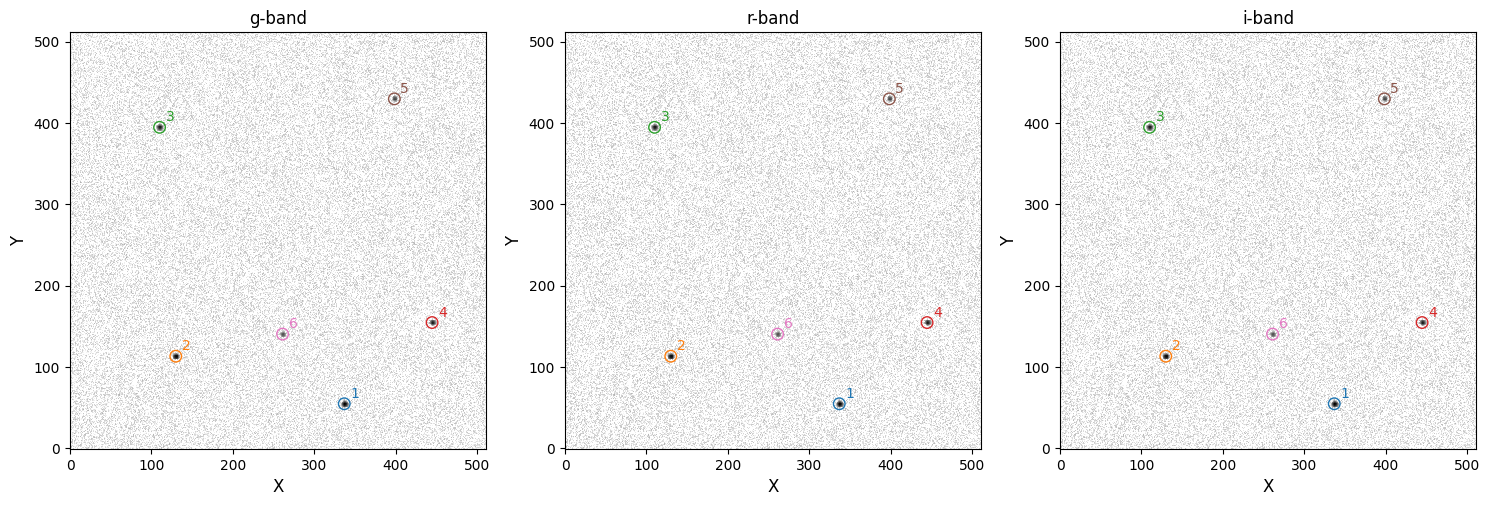

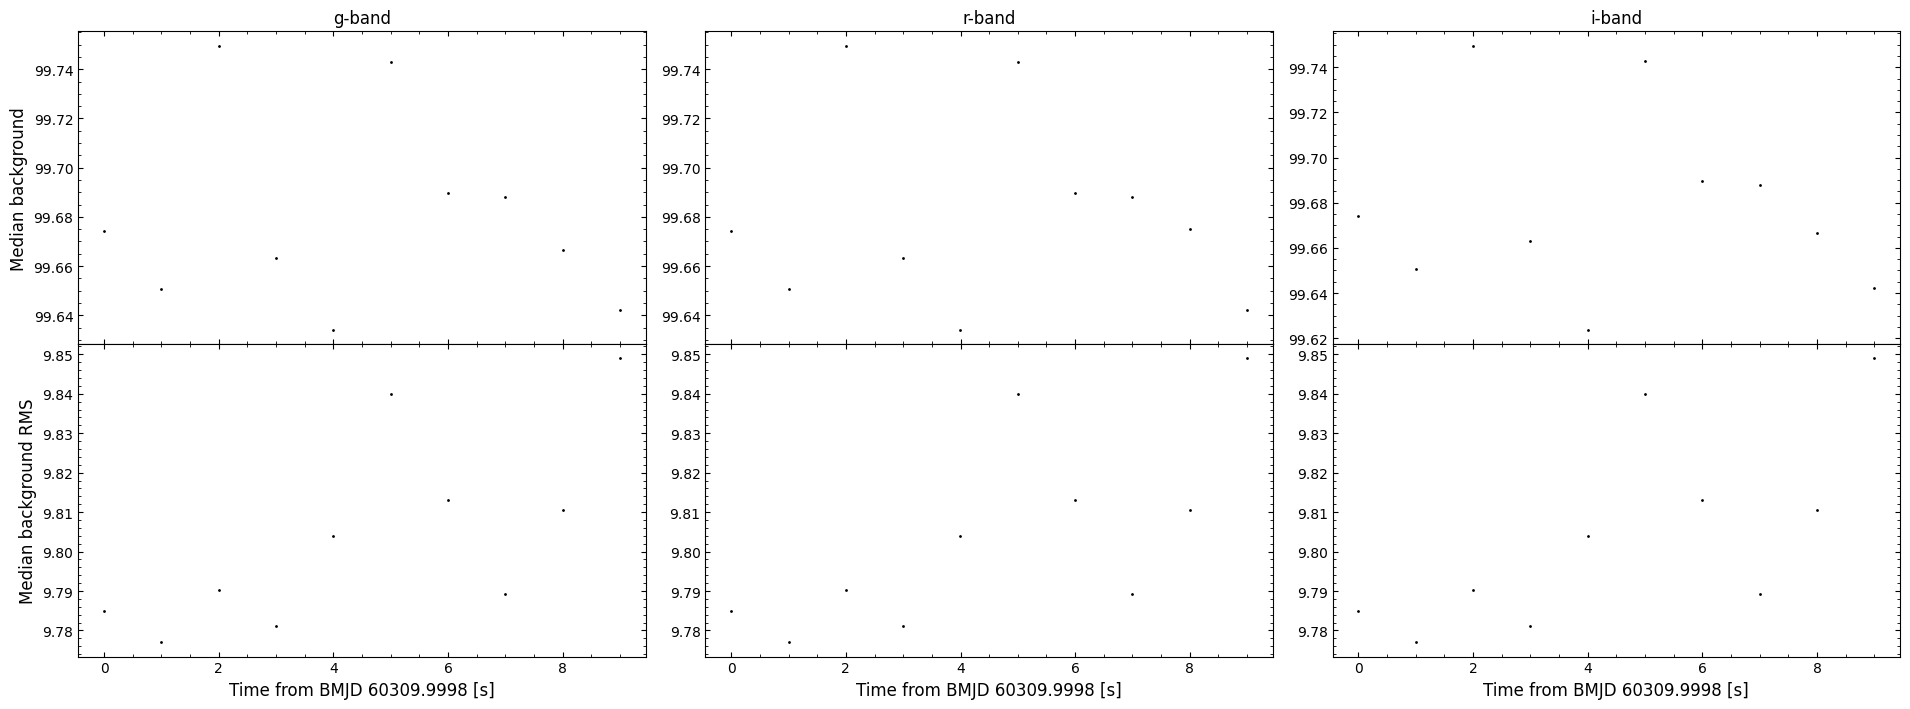

In [16]:
auto_reducer.create_catalogs()

As we can see, the master flats were created and the corrections were applied. For completeness, let's also check if the master flats directory now exists:

In [17]:
os.path.isfile('corrections_tutorial/correctors_auto/master_flats.fits.gz')

True

With just a few lines of code, we have created master flats and used them to correct our observation images!

That concludes the corrections tutorial for `opticam`! Currently, image corrections are limited to flat-field corrections, but we plan to include more complete detector corrections in future.